# Занятие 4: Обучений нейросетей на pytorch

### Практикум на ЭВМ для 317 группы, ВМК МГУ, кафедра ММП

### Варламова Арина, кафедра ММП ВМК МГУ

В данном ноутбуке рассмотрены некоторые аспекты обучения нейросетей с помощью библиотеки Pytorch. Эксперименты проводятся на датасете CIFAR10. 

Официальные туториалы pytorch по этим темам:

* [Neural networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

* [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

In [1]:
import matplotlib.pyplot as plt
plt.style.use('classic')

from IPython import display

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

### Загрузка данных

Загрузим датасет CIFAR10 с помощью стандартной функции из torchvision. При загрузке датасета используем преобразование, нормализующее каналы изображения.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Создадим итераторы по данным:

In [6]:
trainloader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=2)

In [7]:
iter(trainloader).next()[0].size()

torch.Size([64, 3, 32, 32])

Вспомогательная функция:

In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Визуализируем картинки:

 deer   car horse  ship


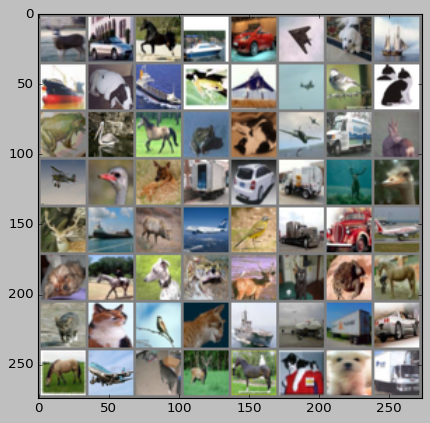

In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Линейная модель классификации

Зададим самую простую — линейную модель. Для задания модели достаточно создать класс, унаследованный от nn.Module и выполняющий инициализацию родительского класса.

Далее необходимо задать функцию forward — процесс прямого прохода в сети. .backward будет реализован автоматически. 

In [10]:
image_size = images[0].shape

In [11]:
class Net(nn.Module):
    def __init__(self, feature_size, n_classes=10):
        super(Net, self).__init__()
        self.feature_size = feature_size
        self.fc1 = nn.Linear(feature_size, n_classes)

    def forward(self, x):
        x = x.view(-1, self.feature_size)
        x = self.fc1(x)
        return x

In [12]:
net = Net(feature_size=np.prod(image_size), n_classes=10)
net = net.cuda()

Задание метода оптимизации и функции потерь:

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

Функция для оценивания качества:

In [14]:
def evaluate_net(net, testloader, use_cuda=True):
    net = net.eval()
    
    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if use_cuda:
                images = images.cuda()
            
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, dim=1)
            
            total += labels.size(0)
            correct += float((predicted == labels).sum())
            loss += float(criterion(outputs, labels))
    
    mean_loss = loss / total
    accuracy = correct / total
    
    return mean_loss, accuracy

In [15]:
def class_evaluation(net, testloader, use_cuda=True):
    net = net.eval()
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if use_cuda:
                images = images.cuda()
            
            outputs = net(images).cpu()
            
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

    class_correct = [
        float(x)
        for x in class_correct
    ]

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [16]:
def plt_graphics(verbose_data):
    plt.clf()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)

    plt.subplot(1, 2, 1)
    plt.plot(verbose_data['train_verbose_steps'],
             verbose_data['train_loss'], 'b', linewidth=2)
    plt.plot(verbose_data['test_verbose_steps'],
             verbose_data['test_loss'], 'r', linewidth=2)
    plt.legend(['train', 'test'], fontsize=14)

    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(verbose_data['test_verbose_steps'],
             verbose_data['test_accuracy'], 'r', linewidth=2)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    plt.grid()
    plt.show()

verbose через print:

In [17]:
def optimize_net(n_epochs, net, trainloader, optimizer, criterion,
                 use_cuda=True, verbose=True, batch_verbose_proportion=0.5):
    net = net.train()
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss)

            # print every 6000 mini-batches
            if verbose:
                if i % n_batches_for_verbose == n_batches_for_verbose - 1:
                    epoch_value = np.around(i / n_batches, 2)
                    print(
                        '[{:.2f}] loss: {:.3f}'
                        .format(epoch_value, running_loss / n_batches_for_verbose)
                    )
                    running_loss = 0.0
                    
                
        if verbose:
            test_loss, test_accuracy = evaluate_net(net, testloader)
            print(
                '[{}] test_accuracy: {:.3f}, test_loss: {:.3f}'
                .format(epoch + 1, test_accuracy, test_loss)
            )
            print('------------------------------')
    
    if verbose:
        print('Finished Training')

verbose через графики:

In [18]:
def optimize_net(n_epochs, net, optimizer, criterion,
                 trainloader, testloader,
                 use_cuda=True, verbose=True, batch_verbose_proportion=0.5, 
                 verbose_data=None):
    net = net.train()
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    
    if verbose_data is None:
        verbose_data = {
            'train_verbose_steps': [],
            'train_loss': [],
            'test_verbose_steps': [],
            'test_loss': [],
            'test_accuracy': [],
        }
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        running_loss = 0.0
        total_objects = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
        
            # move data to cuda if need
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss)
            total_objects += outputs.shape[0]
            
            
            # save info sometimes
            if i % n_batches_for_verbose == n_batches_for_verbose - 1:
                epoch_value = epoch + np.around(i / n_batches, 2)
                new_train_loss = running_loss / total_objects
                running_loss = 0
                total_objects = 0
                
                verbose_data['train_verbose_steps'].append(epoch_value)
                verbose_data['train_loss'].append(new_train_loss * 100)            
                
                if verbose:
                    plt_graphics(verbose_data)
                
        # save info about test 
        test_loss, test_accuracy = evaluate_net(net, testloader)
        verbose_data['test_verbose_steps'].append(epoch + 1)
        verbose_data['test_loss'].append(test_loss * 100)
        verbose_data['test_accuracy'].append(test_accuracy * 100)
            
        if verbose:
            plt_graphics(verbose_data)
            
    return verbose_data

Обучение мультиномиальной регрессии (несколько эпох):

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

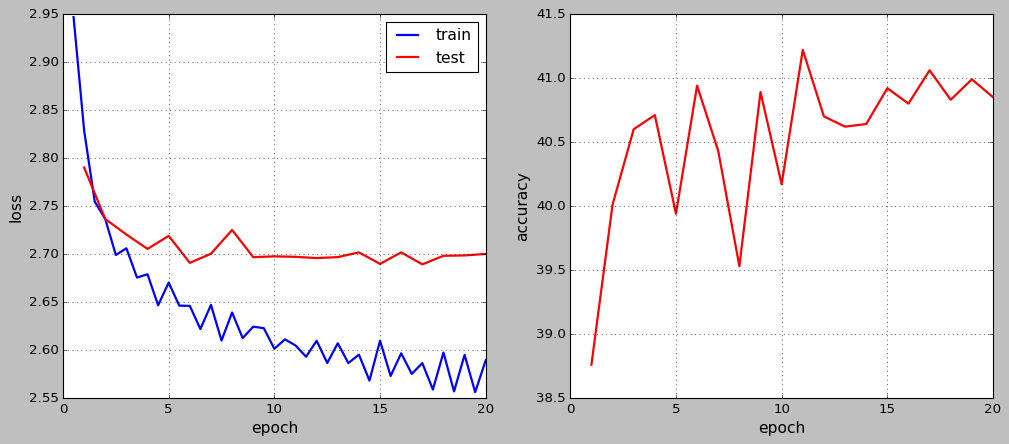

In [19]:
linear_net_data = optimize_net(
    20, net, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)

In [20]:
max(linear_net_data['test_accuracy'])

41.22

In [21]:
class_evaluation(net, testloader)

Accuracy of plane : 53 %
Accuracy of   car : 58 %
Accuracy of  bird : 31 %
Accuracy of   cat : 19 %
Accuracy of  deer : 21 %
Accuracy of   dog : 33 %
Accuracy of  frog : 37 %
Accuracy of horse : 42 %
Accuracy of  ship : 60 %
Accuracy of truck : 47 %


Сеть учится (значение функции потерь уменьшается), но переобучается (начиная с некоторого момента функция потерь на тесте не изменяется, хотя на обучении уменьшается). Линейная модель - слишком простая архитектура для задачи классификации изображений, никак не учитывающая особенность изображений (например то, что соседние пиксели сильно связаны друг с другом).

### LeNet для классификации

Попробуем использовать для классификации свёрточные сети. Для начала рассмотрим очень простую архитектуру LeNet.

In [22]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(120, 84)
        self.relu_fc2 = nn.ReLU()
        
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        x = x.view(batch_size, -1)
        
        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))
        x = self.fc3(x)
        return x

Альтернативная запись этой же сети:

In [24]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes),
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        
        x = x.view(batch_size, -1)
        x = self.fc_layers(x)

        return x

In [23]:
net = Net(n_classes=10)
net = net.cuda()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

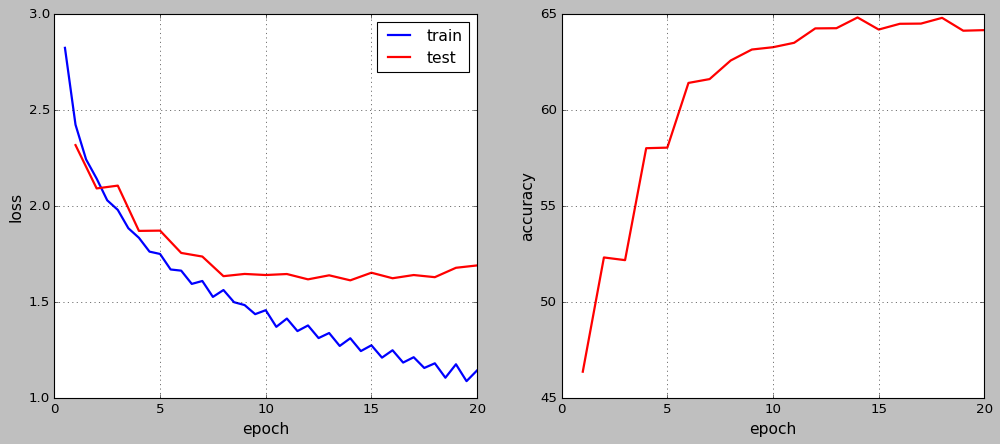

In [27]:
lenet_base_data = optimize_net(
    20, net, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)

In [28]:
max(lenet_base_data['test_accuracy'])

64.82

Сеть сильно переобучается. Попробуем чуть-чуть улучшить результат, используя Dropout:

In [29]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(84, n_classes),
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        
        x = x.view(batch_size, -1)
        x = self.fc_layers(x)

        return x

In [30]:
net = Net(n_classes=10)
net = net.cuda()

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

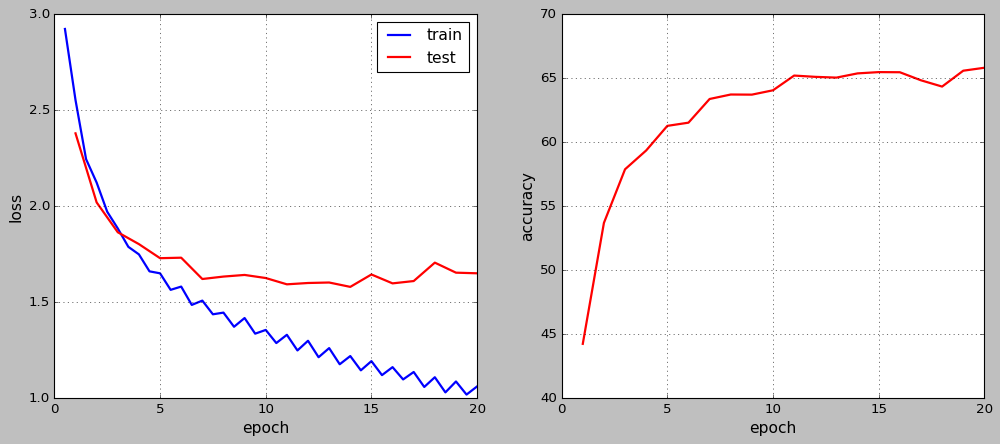

In [32]:
lenet_dropout_data = optimize_net(
    20, net, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)

In [33]:
max(lenet_dropout_data['test_accuracy'])

65.8

In [34]:
class_evaluation(net, testloader)

Accuracy of plane : 80 %
Accuracy of   car : 62 %
Accuracy of  bird : 55 %
Accuracy of   cat : 36 %
Accuracy of  deer : 52 %
Accuracy of   dog : 57 %
Accuracy of  frog : 75 %
Accuracy of horse : 60 %
Accuracy of  ship : 75 %
Accuracy of truck : 74 %


LeNet — очень простая архитектура. Если мы хотим получить хорошее качество, нужно использовать что-то посложнее (например, взять модель из torchvision.models), а также использовать аугментацию данных. Другой путь улучшения результата — использование предобученной сети и дообучение линейного слоя.

### Предобученный ResNet18

In [35]:
from torchvision.models import resnet18

In [36]:
resnet_model = resnet18(pretrained=True)

In [37]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Будем оптимизировать только последний слой в сети:

In [38]:
for parameter in resnet_model.parameters():
    parameter.requires_grad = False

In [39]:
resnet_model.fc = nn.Linear(512, 10)

Так, как ResNet18 обучался на картинках другого размера, необходимо изменить размер наших картинок.

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.resnet_block = resnet_model
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = nn.functional.interpolate(x, scale_factor=8)
        x = self.resnet_block(x)

        return x

In [41]:
net = Net().cuda()

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

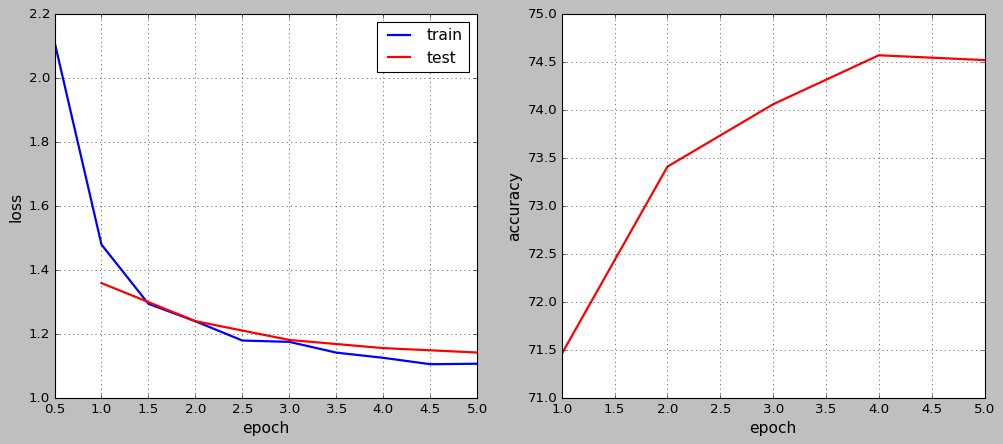

In [43]:
resnet_pretrained_data = optimize_net(
    5, net, optimizer, criterion,
    trainloader, testloader,
    use_cuda=True, verbose=True
)

In [44]:
max(resnet_pretrained_data['test_accuracy'])

74.57000000000001